In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pystan

In [8]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
data = pd.read_csv(path+ 'Electricity_Residential_Price_New_England.csv')

#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [ ]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

In [ ]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

Model 1:

AR(2)

p=2 (number of lags)

$y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_i$, $\alpha$ for $i=1, ...,2$ 

Priors: 

$\alpha \sim N(0, 1)$

$\phi_i \sim N(0, 1)$ for i in $i=1, ...,p$

$\sigma^2 \sim \Gamma^{-1}(a, b)$

Arbitrarily choose $a$ and $b$

Higher values of $b$ would give a wider distribution. And $a=b=1$ is an uniformitive prior. 

In [35]:
m1_stan_code = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int P; // Number of lags for AR element
    
    matrix[T, K] Y; // data to model
        
    // priors
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
}

transformed data{
    matrix[T,P] Y_lagged[K];
        
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] mu; //intercept
    vector<lower=0>[K] sigma;
    matrix[K,P] phi; //lag parameters
}


model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    if (P>0){
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);
        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
        }
    }
    
    err = Y - nu;
    
    for (k in 1:K){
        err[P+1:T,k] ~ normal(0, sigma[k]);
    }
}"""

In [36]:
m1_data = {'T':len(data), 'K':1, 'P':2, 'Y':np.asarray(list(data['Electricity Price'])).reshape(len(data), 1),
           "mu_prior_location": 0, 'mu_prior_scale':1, 'sigma_prior_location': 1, 'sigma_prior_scale':1, 
           'phi_prior_location':0, 'phi_prior_scale':1}


In [37]:
fit = pystan.stan(model_code=m1_stan_code, data=m1_data, iter=2000, warmup = 100, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26ff5e5e2d6f691a794b9714b8a7c9f3 NOW.
/Users/afugere/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [38]:
print(fit)

Inference for Stan model: anon_model_26ff5e5e2d6f691a794b9714b8a7c9f3.
3 chains, each with iter=2000; warmup=100; thin=1; 
post-warmup draws per chain=1900, total post-warmup draws=5700.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      0.11  3.2e-3   0.13  -0.15   0.02    0.1   0.19   0.36   1628    1.0
sigma[0]   0.43  2.7e-4   0.02    0.4   0.42   0.43   0.45   0.47   4816    1.0
phi[0,0]   0.84  1.3e-3   0.06   0.72    0.8   0.84   0.88   0.96   2127    1.0
phi[0,1]   0.15  1.3e-3   0.06   0.03   0.11   0.15   0.19   0.27   2115    1.0
lp__      91.56    0.03   1.48  87.75   90.9  91.89  92.63  93.41   1800    1.0

Samples were drawn using NUTS at Wed Nov 28 17:40:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
fit.plot()


In [ ]:
summary_dic = fit.summary()
df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'], index=summary_dic['summary_rownames'])

In [ ]:
df

In [4]:
mu_mean, sigma_mean, df_phi_0_0_mean, df_phi_0_1_mean = df['mean']['mu[1]'], df['mean']['sigma[1]'], df['mean']['phi[1,1]'], df['mean']['phi[1,2]']

NameError: name 'df' is not defined

In [185]:
mu = fit['mu']
sigma = fit['sigma']
phi1 = [fit['phi'][i][0][0] for i in range(len(sigma))]
phi2 = [fit['phi'][i][0][1] for i in range(len(sigma))]
lp = fit['lp__']

### Alternative way to Look at the Trace Plots

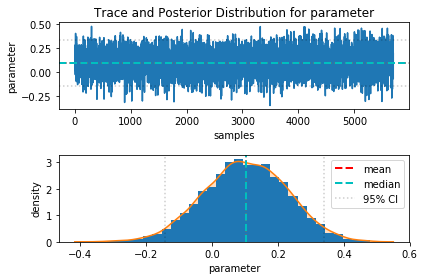

In [186]:
plot_trace(mu)

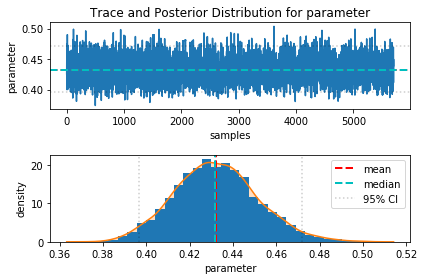

In [187]:
plot_trace(sigma)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


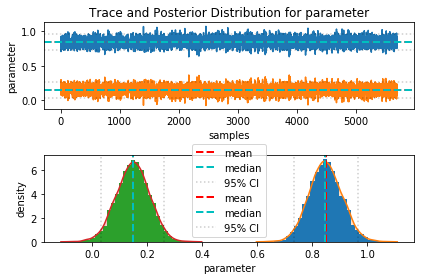

In [188]:
## I can't get this to work for phi
plot_trace(phi1)
plot_trace(phi2)

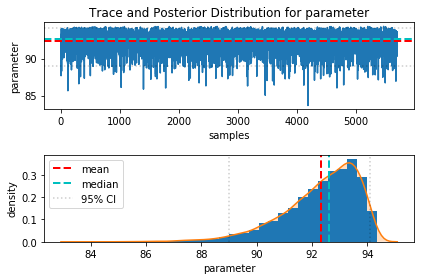

In [189]:
plot_trace(lp)

We seem to have convergence 

[Abby to-do]

    Need to look at these results compared to frequentist methods

    Look at residuals and model diagnostics
    
    Explore different priors
   
    


Model 1:

AR(2)

p=2 (number of lags)

$y_t = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$


In [190]:
mu_hat = df['mean'][0]
sigma_hat = df['mean'][1]
phi1_hat = df['mean'][2]
phi2_hat = df['mean'][3]

In [191]:
y_hat = []
n = len(data['Electricity Price'])
y = list(data['Electricity Price'])
for t in range(n):
    if t > 1:
        #y_hat.append(mu_hat+phi1_hat*y[t-1] + phi2_hat*y[t-2]+np.random.normal(0, sigma_hat))
        y_hat.append(mu_hat+phi1_hat*y[t-1] + phi2_hat*y[t-2])
        # confused about the error term

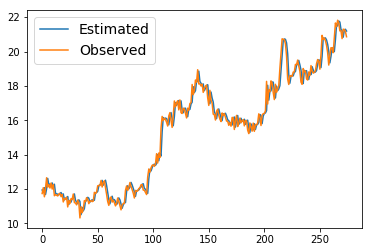

In [192]:
fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Estimated')
ax.plot(y[2:], label = 'Observed')
ax.legend(loc='best', fontsize = 14)


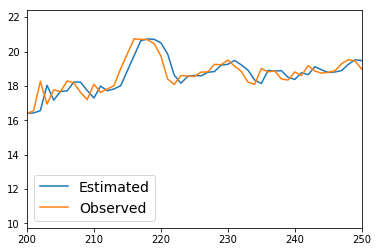

In [193]:
fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Estimated')
ax.plot(y[2:], label = 'Observed')
ax.set_xlim(200,250)
ax.legend(loc='best', fontsize = 14)


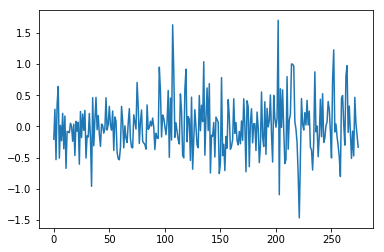

In [194]:
residuals = [obs-exp for obs,exp in zip(y[2:], y_hat)]
plt.plot(residuals)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


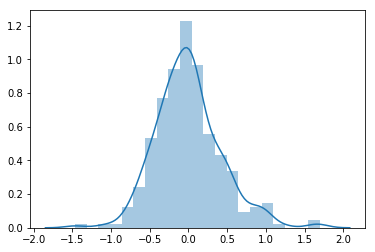

In [195]:
sns.distplot(residuals)

Questions:

    What is the log-likelihood of the model?
        Is that the lp__ from the stan output? 
        
    Need to compute some AIC/BIC values

### ARIMA model

P = number of lags for auto regressive

Q = number of lags for moving average

$y_t = \mu + \phi_1 y_{t-1} + ... +\phi_p y_{t-p}+ w_t +\theta_1 w_{t-1}+...+\theta_q w_{t-q} + \epsilon_t$
[Not sure about notation. It's hard to keep everything straight all of the sources seem to have different notation]

$w_t$ is the moving average

If fitting a model with differencing of 1:

$z_t = y_t - y_{t-1}$

$z_t = \mu + \phi_1 z_{t-1} + ... +\phi_p z_{t-p}+ w_t +\theta_1 w_{t-1}+...+\theta_q w_{t-q}+ \epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_p$, $\theta_q$, $\mu$ for $p=1, ...,P$ and $q=1,...,Q$ 

Priors: 

$\mu \sim N(0, 1)$

$\phi_p \sim N(0, 1)$ for i in $p=1, ...,P$

$\theta_q \sim N(0, 1)$ for i in $q=1, ...,Q$

$\sigma^2 \sim \Gamma^{-1}(a, b)$



In [45]:
# ARIMA Model

stan_code_m2 = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int<lower=0,upper=T-1> P; // Number of lags for AR element
    int<lower=0,upper=T-1> Q; // Number of lags for MA element

    matrix[T, K] Y; // data to model

    // priors
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;

    vector[P] phi_prior_location;
    vector[P] phi_prior_scale;

    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
    int n_missing_observations;
    n_missing_observations = 0;
    for (k in 1:K){
        for (t in 1:T){
            if (is_nan(Y[t,k])){
                n_missing_observations = n_missing_observations + 1;
            }
        }
    }
}

parameters {
    vector[K] mu;
    vector<lower=0>[K] sigma;
    matrix[K,P] phi;
    matrix<lower=-1, upper=1>[K,Q] theta;
    vector[n_missing_observations] latent_data;
    
}

transformed parameters {
    matrix[T,K] Y_latent;


    {
    int latent_data_counter;
    latent_data_counter = 1;

    for (k in 1:K){
        for (t in 1:T){
            if (is_nan(Y[t,k])){
                Y_latent[t,k] = latent_data[latent_data_counter];
                latent_data_counter = latent_data_counter + 1;
            } 
            else{
                Y_latent[t,k] = Y[t,k];
            }
        }
    }
    }
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    matrix[T,P] Y_latent_change_lagged[K];
    matrix[T-1,K] Y_latent_change;

//    Y_latent_change = Y_latent[2:T,:]-Y_latent[1:T-1,:];

    for (k in 1:K){
        Y_latent_change_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_latent_change_lagged[k, 1+p:T,p] = Y_latent[1:T-p,k];
        }
    }

    mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);

    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location[p], phi_prior_scale[p]);
    }
    for (q in 1:Q){
        theta[:,q] ~ normal(theta_prior_location, theta_prior_scale);
    }

    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);

        if (P>0){
            nu[:,k] = nu[:,k] + Y_latent_change_lagged[k]*phi[k]';
            }

        err[:,k] = Y_latent[:,k] - nu[:,k];

        if (Q>0){
            if (Q>1){
                for (t in 2:Q){
                    nu[t,k] = nu[t,k] + theta[k,1:t-1]*err[1:t-1, k];
                    err[t,k] = Y_latent[t,k] - nu[t,k];
                }
            }
            for (t in 1+Q:T){
                nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1,k];
                err[t,k] = Y_latent[t,k] - nu[t,k];
                }
        }

        err[1+max(P,Q):,k] ~ normal(0, sigma[k]);
    }
}"""

In [14]:
y = list(data['Electricity Price'])
z_1 = [y[i] - y[i-1] for i in range(1,len(y))] # data with differencing of 1 lag


In [51]:
m2_data = {'T':len(z_1), 'K':1, 'P':2, 'Q':0, 'Y':np.asarray(z_1).reshape(len(z_1), 1),
           "mu_prior_location": 0, 'mu_prior_scale':1, 'sigma_prior_location': 1, 'sigma_prior_scale':1, 
           'phi_prior_location':[0,0], 'phi_prior_scale':[1,1], 'theta_prior_location':0, 'theta_prior_scale':1}


In [52]:
fit = pystan.stan(model_code=stan_code_m2, data=m2_data, iter=1000, warmup = 100, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a08c6c45d804bba7f3f7ec3a602c8a99 NOW.
/Users/afugere/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [53]:
print(fit)

Inference for Stan model: anon_model_a08c6c45d804bba7f3f7ec3a602c8a99.
3 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=2700.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]             0.04  5.1e-4   0.03  -0.01   0.02   0.04   0.06   0.09   2700    1.0
sigma[0]          0.43  3.9e-4   0.02    0.4   0.42   0.43   0.44   0.47   2369    1.0
phi[0,0]         -0.15  1.4e-3   0.06  -0.27  -0.19  -0.15  -0.11  -0.04   1708    1.0
phi[0,1]         -0.03  1.4e-3   0.06  -0.14  -0.07  -0.03 9.5e-3   0.08   1858    1.0
Y_latent[0,0]    -0.08     0.0    0.0  -0.08  -0.08  -0.08  -0.08  -0.08      2    nan
Y_latent[1,0]     0.34     0.0    0.0   0.34   0.34   0.34   0.34   0.34      2    nan
Y_latent[2,0]    -0.53     0.0    0.0  -0.53  -0.53  -0.53  -0.53  -0.53      2    nan
Y_latent[3,0]     0.49 3.9e-175.6e-17   0.49   0.49   0.49   0.49   0.49      2    nan
Y_latent[4,0]     0.62     0.0

### Bayesian Structural Modeling 
http://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf